In [1]:
import random as rand
import json
import cv2
from matplotlib import pyplot as plt
import albumentations as A

In [2]:
PATH_TO_IMAGES = '/dih4/dih4_2/wimlds/data'
PATH_TO_ANN = '/dih4/dih4_2/wimlds/amikolajczyk/detect-waste/annotations/annotations_test.json'

In [3]:
with open(PATH_TO_ANN, 'r') as f:
        annotations = json.loads(f.read())

In [4]:
def rand_image(PATH_TO_IMAGES, annotations):
    im_id = rand.randint(0,len(annotations['images']))
    annotation, image = annotations['annotations'], annotations['images'][im_id]
    bboxes = [ann['bbox'] for ann in annotation if ann['image_id'] == image['id']]
    category_ids = [ann['category_id'] for ann in annotation if ann['image_id'] == image['id']]
    return image['file_name'], bboxes, category_ids

In [5]:
categories = annotations['categories']
category_id_to_name={}
for cat in categories:
    category_id_to_name[cat['id']] = cat['name']

In [6]:
BOX_COLOR = (255,0,0) # red
TEXT_COLOR = (255,255,255) # white
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=4):
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, FONT, 0.35,1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)),(x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text = class_name,
        org = (x_min, y_min - int(0.3 * text_height)),
        fontFace = FONT,
        fontScale = 0.35,
        color = TEXT_COLOR,
        lineType = cv2.LINE_AA,
        )
    
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    if isinstance(category_ids, list):
        for bbox, category_id in zip(bboxes, category_ids):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name)
    else:
        class_name = category_id_to_name[category_ids]
        img = visualize_bbox(img, bboxes, class_name)
            
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(img)

# Visualize original annotations

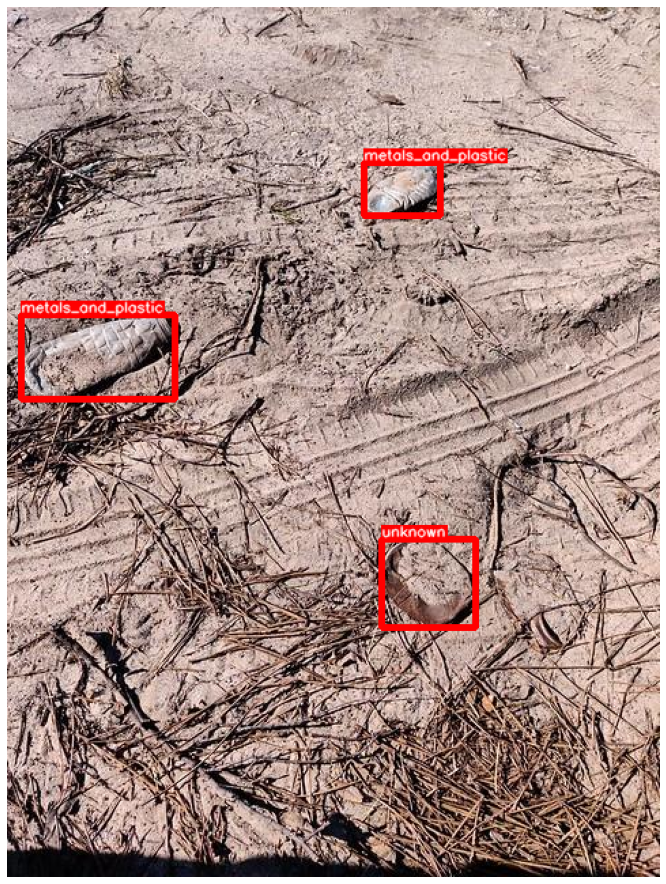

In [7]:
path_to_im, bbox, category_id = rand_image(PATH_TO_IMAGES, annotations)
image = cv2.imread(PATH_TO_IMAGES+'/'+path_to_im)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image, bbox, category_id, category_id_to_name)

In [8]:
import torch.nn.parallel
from contextlib import suppress

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from effdet.evaluator import CocoEvaluator, PascalEvaluator
from timm.utils import AverageMeter, setup_default_logging

model = 'tf_efficientdet_d2'
# create model
bench = create_model(
    'tf_efficientdet_d2',
    bench_task='predict',
    num_classes=7,
    pretrained=False,
    redundant_bias=True,
    checkpoint_path='../output/train/20201221-212419-tf_efficientdet_d2/model_best.pth.tar'
)
model_config = bench.config

param_count = sum([m.numel() for m in bench.parameters()])
print('Model %s created, param count: %d' % (model, param_count))

bench = bench.cuda()


Model tf_efficientdet_d2 created, param count: 8012628


In [11]:
import argparse

dataset = create_dataset('DetectwasteCfg', path_to_im)
parser = argparse.ArgumentParser(description='PyTorch ImageNet Validation')
parser.add_argument('-b', '--batch-size', default=1, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
args = parser.parse_args()
input_config = resolve_input_config(args, model_config)
loader = create_loader(
    dataset,
    input_size=input_config['input_size'],
    batch_size=args.batch_size,
    use_prefetcher=False,
    interpolation=input_config['interpolation'],
    fill_color=input_config['fill_color'],
    mean=input_config['mean'],
    std=input_config['std'],
    num_workers=4,
    pin_mem=False)

evaluator = create_evaluator(args.dataset, dataset, neptune = None, pred_yxyx=False)
bench.eval()
with torch.no_grad():
    for i, (input, target) in enumerate(loader):
        output = bench(input, img_info=target)
        print(output)



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


usage: ipykernel_launcher.py [-h] [-b N]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/amikolajczyk/.local/share/jupyter/runtime/kernel-83a17a57-ae92-4c0c-bc71-32d191b6c992.json


SystemExit: 2